# 모델링
데이터 전처리, 정수 인코딩, 패딩의 과정을 거쳐 LSTM 모델로 학습했다. 최종적으로는 임베딩과 LSTM 층 사이에 은닉층을 하나 더 쌓은 모델이 가장 좋았고, Randomized Searh CV, Grid search CV로 하이퍼 파라미터 튜닝을 했을 때 0.8954의 정확도를 가진 모델을 만들 수 있었다. 

In [ ]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

In [ ]:
!pip install konlpy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import os
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from collections import Counter

In [3]:
DATA_PATH = '...../fifa_comment/data/'

In [7]:
df = pd.read_csv(f'{DATA_PATH}sentiment_scores.csv')

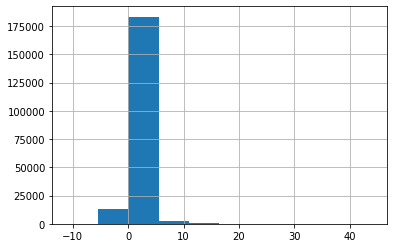

In [ ]:
df['score'].hist()

,userId,player_name,position,comment,rating,score,label
199876,클롭광팬,박지수,df,선수체감 자체가 엄청 가볍고 민첩함,4.00,1,1
199877,클롭광팬,박지수,df,주력이랑 방향전환 모두 빨라가지고 수비커버 범위도 넓게 가져갈수 있음.,4.00,0,0
199878,클롭광팬,박지수,df,5카 기준 2천만bp 정도로 대장급 공격수들을 스피드로 제압가능.. 우리집 센터백은...,4.00,-1,0
199879,레알의라장군,카르바할,df,좋기만한데....,4.04,0,0
199880,자기엘카,조 고메스,df,단점 헤딩 실존이랑 똑같음,3.83,0,0


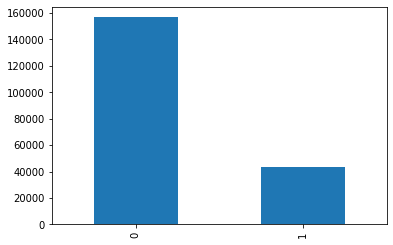

In [ ]:
#0보다 크면 긍정(1), 같거나 작으면 부정(0)
df.loc[df.score > 0, 'label'] = 1
df.loc[df.score <= 0, 'label'] = 0
df.label = df.label.astype(int)
display(df.tail())
df.label.value_counts().plot(kind = 'bar')

In [ ]:
#감성분석에 필요한 comment와 label만 남겨두기
df = df[['comment', 'label']]
df.tail()

,comment,label
199876,선수체감 자체가 엄청 가볍고 민첩함,1
199877,주력이랑 방향전환 모두 빨라가지고 수비커버 범위도 넓게 가져갈수 있음.,0
199878,5카 기준 2천만bp 정도로 대장급 공격수들을 스피드로 제압가능.. 우리집 센터백은...,0
199879,좋기만한데....,0
199880,단점 헤딩 실존이랑 똑같음,0


In [ ]:
print(df.duplicated().sum())
print(df.isnull().sum().sum())

5316
0


In [ ]:
#중복제거
df.drop_duplicates(inplace = True)
print(df.duplicated().sum())
df.shape

0


(194565, 2)

In [ ]:
X_train, X_test = train_test_split(df, test_size = 0.2, 
                                    random_state = 42, stratify = df['label'])
display(X_train.tail())
print(X_train.shape)
display(X_test.tail())
print(X_test.shape)

,comment,label
193578,진첸코 확률상 기준으로 1카사다가 5카까지 강화시에 드는 금액 약 9천.그냥 사라....,0
69987,22토티보다 급여 1낮고 크게 차이 못느껴서 21토츠 쓰는중 가격이 말햐준다,0
185831,모름 ㅋㅋ 근데 하루종일 빨간불이라알파 안받아도 언제든 팔려서 파는사람은 안급함,0
3873,5글읽음? 써봤다잖아 일단 안써봤다라고 시작하는 븅들은 뭐냐 ㅋㅋ 겜을 허구헌날 해...,0
185605,6카 상한에 올렸슴니다 팔아주십쇼 ㅠㅠ,0


(155652, 2)


,comment,label
31003,저능아새낀가 ㅋㅋㅋ똑같은 세글자를 못읽는척하고있네고아새낀가 기본적인걸 못배웠어,0
70000,윙에서 조금 한계 느껴서 원톱 뒀는데 속이 다 시원함 음바페도 울고갈 순간침투 약발...,0
177840,금카좀 사자~! 몇번을 6에서 넘어지니 ㅠ,0
3298,나만그런줄알았는대 ;;;,0
103541,속가가 너무느려서그런거아닐까요?,0


(38913, 2)


In [ ]:
#숫자, 알파벳, 한글, .외에는 모두 제거
X_train['comment'] = X_train['comment'].str.replace('[^0-9a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣 ]','')
X_train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,comment,label
181933,맨시티 구단에 고급여 풀백으로 쓸라고 은카만 샀는데 걍 바로 LAM RAM번갈아 가...,0
180650,부캐뮌헨에3카사용중좋긴함 1티어는 너무보유자욕심인것같고솔직히 15티어가적당 블랑보다...,0
56712,에투나 조징웨아 같은 애들 나와서 얘 좀 조져줬으면,0
120518,판매완료하한 거니까 금세 팔리네걱정했는데 ㅎㅎ,0
128863,4카 쓰는데 솔직히 티티 비에이라 5카랑 수비력은 큰 차이 못느끼겠음 오히려 밀어내...,1


In [ ]:
#테스트 데이터도
X_test['comment'] = X_test['comment'].str.replace('[^0-9a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣 ]','')
X_test.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,comment,label
176804,8카후기매물이 있길래 급여 아낄겸 구매했는데 생각보다 괜춘함 근데 이새끼쓰다가 카르...,0
143834,와크로스 하나는 일품이네올리는 족족 골 선물임 ㅋㅋㅋ맨유 우측 졸업,0
28949,노미니mc,0
77013,잉국 5카 풀케미 기준얘는 내가 정말 좋아해서 얘는 이번에 4번째 쓰는데 쓰는방법 ...,1
19489,프로게이머들이 버린 선수인데 여기는 왜이리 호평이 많지,0


In [ ]:
print(X_train.isnull().sum().sum())
print(X_test.isnull().sum().sum())
print(X_train.duplicated(subset = 'comment').sum())
print(X_test.duplicated(subset = 'comment').sum())

0
0
741
47


In [ ]:
#중복 확인 및 제거
display(X_train[X_train.duplicated(subset = 'comment')].head())
display(X_test[X_test.duplicated(subset = 'comment')].head())

X_train.drop_duplicates(subset = 'comment',inplace = True)
X_test.drop_duplicates(subset = 'comment',inplace = True)
print(X_train.duplicated().sum())
print(X_test.duplicated().sum())

,comment,label
67681,금카 구매합니다,0
185798,감사합니다,0
69222,금카 올렸습니다,0
177780,7카 구해봅니다,0
111061,금카 올렸습니다,0


,comment,label
113942,혹시 팔렸나요,0
61229,혹시 팔렸나요,0
77101,금카구해요,0
24590,팔아주신분 감사합니다,0
104028,금카 팜,0


0
0


In [ ]:
X_train.shape, X_test.shape

((154911, 2), (38866, 2))

In [ ]:
# 불용어 사전
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', 
             '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '구매합니다', '올렸습니다',
             '팔렸나요', '팔아주신분', '얼만가요', '판매합니다']

In [ ]:
mecab = Mecab()

# 토큰화, 불용어 제거
X_train['tokenized'] = X_train['comment'].apply(mecab.morphs)
X_train['tokenized'] = X_train['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

X_test['tokenized'] = X_test['comment'].apply(mecab.morphs)
X_test['tokenized'] = X_test['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [ ]:
#긍정과 부정 단어는 어떤 단어들이 많이 나올까
negative_words = np.hstack(X_train[X_train.label == 0]['tokenized'].values)
positive_words = np.hstack(X_test[X_test.label == 1]['tokenized'].values)

In [ ]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(10))

[('카', 63095), ('좋', 34303), ('쓰', 33787), ('면', 30714), ('는데', 28809), ('ㅋㅋㅋ', 23053), ('음', 22931), ('안', 22624), ('있', 21748), ('거', 20383)]


In [ ]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(10))

[('좋', 13350), ('카', 7443), ('음', 7370), ('면', 5875), ('쓰', 5637), ('는데', 4877), ('있', 4448), ('로', 4369), ('으로', 4146), ('안', 4069)]


In [ ]:
positive_len = X_train[X_train.label == 1]['tokenized'].map(lambda x: len(x))
negative_len = X_train[X_train.label == 0]['tokenized'].map(lambda x: len(x))
print('긍정리뷰 평균 길이', np.mean(positive_len)) # 긍정리뷰 길이가 부정리뷰보다 훨씬 길다.
print('부정리뷰 평균 길이', np.mean(negative_len))

긍정리뷰 평균 길이 62.981199275996964
부정리뷰 평균 길이 23.539604001425527


In [ ]:
X_train_tokenized = X_train['tokenized'].values
X_test_tokenized = X_test['tokenized'].values
y_train = X_train['label'].values
y_test = X_test['label'].values


In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(154911, 3) (154911,) (38866, 3) (38866,)


In [ ]:
X_train_tokenized[0][:10]

['맨', '시티', '구단', '고급', '여', '풀백', '으로', '쓸라', '카', '만']

In [ ]:
# 정수 인코딩
t = Tokenizer()
t.fit_on_texts(X_train_tokenized)

In [ ]:
threshold = 2
total_cnt = len(t.word_index) #단어 수
rare_cnt = 0 # 2번보다 적게 나온 단어 갯수
total_freq = 0 #학습 데이터 전체 단어의 빈도수 합
rare_freq = 0 # 희귀 단어 전체의 빈도수 합

for key,value in t.word_counts.items():
  total_freq = total_freq + value

  if value < threshold:
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('전체 단어의 수', total_cnt)
print('2번 이하로 등장한 희귀 단어 수', rare_cnt)
print('전체 단어 중 희귀 단어 비율', (rare_cnt / total_cnt) * 100)
print('전체 단어의 빈도에서 희귀 단어 빈도의 비율', (rare_freq / total_freq) * 100)

#전체 단어 중 희귀 단어가 46퍼센트지만 등장 빈도는 0.5% 밖에 되지 않기 때문에 별로 중요하지 않을 것 같다.
#희귀단어를 제거해보자.

전체 단어의 수 52059
2번 이하로 등장한 희귀 단어 수 24394
전체 단어 중 희귀 단어 비율 46.858372231506564
전체 단어의 빈도에서 희귀 단어 빈도의 비율 0.48811663894656127


In [ ]:
# 전체 단어 - 희귀 단어 = 2번 이상 등장한 단어.
# 빈도수가 높은 단어순으로 저장되기 때문에.
# +2는 패딩과 OOV 토큰 고려

vocab_size = total_cnt - rare_cnt + 2
print(vocab_size)

27667


In [ ]:
t = Tokenizer(vocab_size, oov_token = 'OOV') 
t.fit_on_texts(X_train_tokenized)
X_train_encoded = t.texts_to_sequences(X_train_tokenized)
X_test_encoded = t.texts_to_sequences(X_test_tokenized)

print(X_train_encoded[:2])
print(X_test_encoded[:2])

[[243, 717, 956, 937, 375, 205, 11, 6344, 2, 24, 327, 7, 194, 287, 1761, 1822, 2430, 28, 99, 530, 103, 106, 158, 269, 153, 1778, 248, 205, 165, 521, 333, 143, 53, 750, 45, 3324, 9001, 10, 117, 29, 263, 45, 8, 6, 242, 98, 26, 1312, 529, 223, 372, 14, 112, 56, 32], [1164, 469, 34, 2, 52, 25, 3, 93, 32, 33, 167, 59, 2098, 3508, 87, 27, 242, 662, 167, 1160, 1126, 40, 6956, 1022, 77]]
[[193, 2, 154, 446, 8, 558, 41, 2479, 1830, 259, 83, 7, 56, 40, 7475, 114, 282, 4, 94, 3610, 4, 5, 205, 8088, 32, 660, 93, 32], [91, 181, 1201, 575, 5607, 81, 9567, 13, 243, 337, 1777, 1209]]


In [ ]:
# 패딩
print('리뷰 최대 길이 ', max(len(review) for review in X_train_encoded))
print('리뷰 평균 길이 ', sum(map(len, X_train_encoded)) / len( X_train_encoded))

리뷰 최대 길이  2056
리뷰 평균 길이  32.26094983571212


In [ ]:
def below_threshold_len(max_len, data):
  count = 0
  for sentence in data:
    if(len(sentence) <= max_len):
        count = count + 1
  print(count / len(data)*100)

In [ ]:
# 길이를 200으로 하면 약 98퍼센트 이상 데이터를 보존할 수 있다.
# 200으로 패딩하자.
below_threshold_len(200, X_train_encoded)

98.76961610214897


In [ ]:
max_len = 200
X_train_padded = pad_sequences(X_train_encoded, maxlen = max_len)
X_test_padded = pad_sequences(X_test_encoded, maxlen = max_len)
X_train_padded[0][100:150]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 243, 717, 956, 937, 375], dtype=int32)

In [ ]:
# train_padded = pd.DataFrame(X_train_padded)
# test_padded = pd.DataFrame(X_test_padded)
# pd.DataFrame(y_train).to_csv('/content/drive/MyDrive/AI_camp_data/Section4/project/y_train.csv', index =False)
# pd.DataFrame(y_test).to_csv('/content/drive/MyDrive/AI_camp_data/Section4/project/y_test.csv', index =False)
# train_padded.to_csv('/content/drive/MyDrive/AI_camp_data/Section4/project/train_padded.csv', index =False)
# test_padded.to_csv('/content/drive/MyDrive/AI_camp_data/Section4/project/test_padded.csv', index =False)

# train_padded.head()


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0,0,0,0,0,0,0,0,0,0,...,98,26,1312,529,223,372,14,112,56,32
1,0,0,0,0,0,0,0,0,0,0,...,27,242,662,167,1160,1126,40,6956,1022,77
2,0,0,0,0,0,0,0,0,0,0,...,5829,28,27,131,815,31,57,3889,961,109
3,0,0,0,0,0,0,0,0,0,0,...,505,1212,12,197,21398,1566,783,83,7,443
4,0,0,0,0,0,0,0,0,0,0,...,5487,5,18,270,415,314,122,120,323,162


## 1. 추가적인 Dense층 없이 임베딩층과 LSTM 층만 쌓아서 모델링
임베딩 차원: 300

은닉층의 노드 갯수: 256

활성화함수: sigmoid

성능지표: accuracy

손실함수: binary crossentropy

옵티마이저: Adam

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout,BatchNormalization
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

embedding_dim = 300
hidden_units = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim)) # 임베딩층
model.add(LSTM(hidden_units)) # LSTM
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('/content/drive/MyDrive/AI_camp_data/Section4/project/best_lstm_model_fifa.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_padded, y_train, epochs=100, callbacks=[es, mc], batch_size=128, validation_split=0.2)

Epoch 1/100
969/969 [==============================] - ETA: 0s - loss: 0.3007 - accuracy: 0.8636
Epoch 1: val_accuracy improved from -inf to 0.88936, saving model to /content/drive/MyDrive/AI_camp_data/Section4/project/best_lstm_model_fifa.h5
969/969 [==============================] - 107s 108ms/step - loss: 0.3007 - accuracy: 0.8636 - val_loss: 0.2471 - val_accuracy: 0.8894
Epoch 2/100
969/969 [==============================] - ETA: 0s - loss: 0.2255 - accuracy: 0.8970
Epoch 2: val_accuracy did not improve from 0.88936
969/969 [==============================] - 103s 107ms/step - loss: 0.2255 - accuracy: 0.8970 - val_loss: 0.2437 - val_accuracy: 0.8858
Epoch 3/100
969/969 [==============================] - ETA: 0s - loss: 0.1968 - accuracy: 0.9111
Epoch 3: val_accuracy did not improve from 0.88936
969/969 [==============================] - 106s 110ms/step - loss: 0.1968 - accuracy: 0.9111 - val_loss: 0.2499 - val_accuracy: 0.8812
Epoch 4/100
969/969 [==============================] - E

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/AI_camp_data/Section4/project/best_lstm_model_fifa.h5')
print("\n 학습 정확도: %.4f" % (loaded_model.evaluate(X_train_padded, y_train)[1]))

4841/4841 [==============================] - 32s 6ms/step - loss: 0.2293 - accuracy: 0.8974

 학습 정확도: 0.8974


In [ ]:
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test_padded, y_test)[1]))

1215/1215 [==============================] - 8s 6ms/step - loss: 0.2473 - accuracy: 0.8883

 테스트 정확도: 0.8883


## 하이퍼 파라미터 튜닝

In [8]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout,BatchNormalization
import tensorflow as tf
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [9]:
vocab_size = 27667

In [10]:
#패딩까지 해놓은 데이터 가져오기
X_train_padded = pd.read_csv(f'{DATA_PATH}train_padded.csv')
X_test_padded = pd.read_csv(f'{DATA_PATH}test_padded.csv')
y_train = pd.read_csv(f'{DATA_PATH}y_train.csv')
y_test = pd.read_csv(f'{DATA_PATH}y_test.csv')

X_train_padded = X_train_padded.values
X_test_padded = X_test_padded.values
y_train = y_train['0'].values
y_test = y_test['0'].values

display(X_train_padded[0][100:150])
display(y_train[:10])

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 243, 717, 956, 937, 375])

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0])

In [6]:
def make_model_rscv(units = 128, activation = 'relu', dropout_rate = 0.3, C = 0.01, optimizer = 'adam'):
  embedding_dim = 300
  hidden_units = 256
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim)) # 임베딩층
  model.add(Dense(units, activation = activation))
  model.add(BatchNormalization())
  model.add(Dense(256, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rate))
  model.add(Dense(128, activation = 'relu',
            kernel_regularizer = regularizers.l2(C),
            activity_regularizer = regularizers.l1(C)))
  model.add(BatchNormalization())
  model.add(LSTM(hidden_units)) # LSTM
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])  

  return model

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

np.random.seed(42)
tf.random.set_seed(42)

units = np.arange(32,512,32)
epochs = [5,10,20,25]
batch_size = [32,64,128,256]
activation = ['relu', 'sigmoid']
optimizer = ['adam', 'adagrad', 'rmsprop']
dropout_rate = [0.2,0.3,0.4,0.5]
C = [0.01,0.1,1]

param_grid = dict(batch_size = batch_size, units = units, activation = activation, optimizer = optimizer, dropout_rate = dropout_rate, C = C, epochs = epochs)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)

model_rscv = KerasClassifier(build_fn=make_model_rscv, verbose=0, callbacks = [es])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [9]:
rscv = RandomizedSearchCV(
    estimator=model_rscv,
    param_distributions=param_grid,
    n_iter=5,
    cv=2,
    scoring='accuracy',
    verbose=3,
    n_jobs=1,
    random_state=42)

rscv_result = rscv.fit(X_train_padded, y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Epoch 12: early stopping
[CV 1/2] END C=1, activation=sigmoid, batch_size=64, dropout_rate=0.4, epochs=20, optimizer=adam, units=160;, score=0.778 total time= 8.7min
Epoch 13: early stopping
[CV 2/2] END C=1, activation=sigmoid, batch_size=64, dropout_rate=0.4, epochs=20, optimizer=adam, units=160;, score=0.780 total time= 8.8min
[CV 1/2] END C=1, activation=sigmoid, batch_size=128, dropout_rate=0.4, epochs=20, optimizer=adam, units=64;, score=0.778 total time= 9.8min
Epoch 11: early stopping
[CV 2/2] END C=1, activation=sigmoid, batch_size=128, dropout_rate=0.4, epochs=20, optimizer=adam, units=64;, score=0.780 total time= 5.5min
[CV 1/2] END C=0.01, activation=relu, batch_size=128, dropout_rate=0.4, epochs=5, optimizer=rmsprop, units=224;, score=0.857 total time= 3.0min
[CV 2/2] END C=0.01, activation=relu, batch_size=128, dropout_rate=0.4, epochs=5, optimizer=rmsprop, units=224;, score=0.846 total time= 2.9min
[CV 1/2] END 

In [10]:
rs = pd.DataFrame(rscv_result.cv_results_).sort_values(by='rank_test_score').head()
rs.T

,2,0,1,3,4
mean_fit_time,157.171974,468.185427,438.079422,220.838607,138.492929
std_fit_time,0.130579,18.585254,126.74288,0.030099,7.001408
mean_score_time,19.060461,55.635685,18.684145,18.412591,18.701125
std_score_time,1.917653,16.454812,2.343133,2.566958,2.261585
param_units,224,160,64,32,160
param_optimizer,rmsprop,adam,adam,rmsprop,rmsprop
param_epochs,5,20,20,5,5
param_dropout_rate,0.4,0.4,0.4,0.2,0.4
param_batch_size,128,64,128,32,256
param_activation,relu,sigmoid,sigmoid,relu,sigmoid


In [11]:
print(f"Best: {rscv_result.best_score_} using {rscv_result.best_params_}")

Best: 0.8516115341295852 using {'units': 224, 'optimizer': 'rmsprop', 'epochs': 5, 'dropout_rate': 0.4, 'batch_size': 128, 'activation': 'relu', 'C': 0.01}


### 오히려 성능이 떨어짐.
### 규제와 Dropout를 없애고, 몇몇 하이퍼 파라미터는 수동으로 조절해보자.
### 결론: 성능 올라감.

In [12]:
def make_model_rscv2(units = 128, activation = 'relu', optimizer = 'adam'):
  embedding_dim = 300
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim)) # 임베딩층
  model.add(Dense(units, activation = activation, kernel_initializer='he_normal')) # he 가중치 초기화
  model.add(BatchNormalization())
  model.add(LSTM(units)) # LSTM
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])  

  return model

In [18]:
np.random.seed(42)
tf.random.set_seed(42)

units = np.arange(32,256,32)
epochs = [10,20,25]
batch_size = [32,64,128,256]
activation = ['relu', 'sigmoid', 'tanh']
optimizer = ['adam', 'adagrad', 'rmsprop']

param_grid = dict(batch_size = batch_size, units = units, activation = activation, optimizer = optimizer, epochs = epochs)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)

model_rscv = KerasClassifier(build_fn=make_model_rscv2, verbose=0, callbacks = [es])

<ipython-input-18-06d656721611>:13: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_rscv = KerasClassifier(build_fn=make_model_rscv2, verbose=0, callbacks = [es])


In [37]:
start = time.time()
with tf.device('/GPU:0'):
    rscv = RandomizedSearchCV(
        estimator=model_rscv,
        param_distributions=param_grid,
        n_iter=5,
        cv=2,
        scoring='accuracy',
        verbose=1,
        n_jobs=2,
        random_state=42)

    rscv_result = rscv.fit(X_train_padded, y_train)

print((time.time() - start)/60)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   53.8s finished


1269.1228284835815


In [38]:
rs = pd.DataFrame(rscv_result.cv_results_).sort_values(by='rank_test_score').head()
rs.T

,0,1,2,3,4
mean_fit_time,11.1502,10.1924,10.2126,10.1961,10.196
std_fit_time,0.00711405,0.00508225,0.00756729,0.00314295,0.00346446
mean_score_time,0,0,0,0,0
std_score_time,0,0,0,0,0
param_units,160,64,160,64,64
param_optimizer,rmsprop,rmsprop,rmsprop,adam,adagrad
param_epochs,20,25,10,25,10
param_batch_size,64,128,32,64,64
param_activation,relu,sigmoid,sigmoid,relu,relu
params,"{'units': 160, 'optimizer': 'rmsprop', 'epochs...","{'units': 64, 'optimizer': 'rmsprop', 'epochs'...","{'units': 160, 'optimizer': 'rmsprop', 'epochs...","{'units': 64, 'optimizer': 'adam', 'epochs': 2...","{'units': 64, 'optimizer': 'adagrad', 'epochs'..."


In [39]:
print(f"Best: {rscv_result.best_score_} using {rscv_result.best_params_}")

Best: nan using {'units': 160, 'optimizer': 'rmsprop', 'epochs': 20, 'batch_size': 64, 'activation': 'relu'}


In [46]:
np.random.seed(42)
tf.random.set_seed(42)

units = rscv_result.best_params_.get('units')
optimizer = rscv_result.best_params_.get('optimizer')
batch_size = rscv_result.best_params_.get('batch_size')
activation = rscv_result.best_params_.get('activation')
epochs = rscv_result.best_params_.get('epochs')

best_model = make_model_rscv2(units = units, activation = activation,optimizer = optimizer)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(f'{DATA_PATH}best_lstm_model_fifa2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

with tf.device('/GPU:0'):
    history = best_model.fit(X_train_padded, y_train, epochs = epochs, batch_size = batch_size, callbacks = [es,mc], 
                             validation_split=0.2)

Epoch 1/20
1936/1937 [============================>.] - ETA: 0s - loss: 0.2763 - accuracy: 0.8754
Epoch 1: val_accuracy improved from -inf to 0.88862, saving model to /home/isds/이민구/doc/fifa_comment/data/best_lstm_model_fifa2.h5
1937/1937 [==============================] - 59s 30ms/step - loss: 0.2763 - accuracy: 0.8754 - val_loss: 0.2481 - val_accuracy: 0.8886
Epoch 2/20
1937/1937 [==============================] - ETA: 0s - loss: 0.2311 - accuracy: 0.8971
Epoch 2: val_accuracy improved from 0.88862 to 0.89136, saving model to /home/isds/이민구/doc/fifa_comment/data/best_lstm_model_fifa2.h5
1937/1937 [==============================] - 57s 29ms/step - loss: 0.2311 - accuracy: 0.8971 - val_loss: 0.2378 - val_accuracy: 0.8914
Epoch 3/20
1936/1937 [============================>.] - ETA: 0s - loss: 0.2125 - accuracy: 0.9072
Epoch 3: val_accuracy did not improve from 0.89136
1937/1937 [==============================] - 57s 29ms/step - loss: 0.2125 - accuracy: 0.9072 - val_loss: 0.2484 - val_ac

In [47]:
loaded_model = load_model(f'{DATA_PATH}best_lstm_model_fifa2.h5')
#print("\n 학습 정확도: %.4f" % (loaded_model.evaluate(X_train_padded, y_train)[1]))

In [48]:
# Basic 모델의 성능인 0.88에서 0.89로 성능이 향상된 것을 확인할 수 있다.
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test_padded, y_test)[1]))

1215/1215 [==============================] - 14s 12ms/step - loss: 0.2374 - accuracy: 0.8938

 테스트 정확도: 0.8938


## Grid Search CV
Randomized Search CV에서 찾은 범위를 참고해서 세부적으로 튜닝해보자.

In [30]:
units = [64,128,256]
epochs = [20]
batch_size = [128,256] # GPU 메모리가 부족하면, batch size를 늘리자.
activation = ['relu', 'sigmoid']
optimizer = ['rmsprop', 'adam']

param_grid = dict(batch_size = batch_size, units = units, activation = activation, optimizer = optimizer, epochs = epochs)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)

model_grid = KerasClassifier(build_fn=make_model_rscv2, verbose=0, callbacks = [es])

<ipython-input-30-8f6d4b40239d>:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_grid = KerasClassifier(build_fn=make_model_rscv2, verbose=0, callbacks = [es])


In [31]:
np.random.seed(42)
tf.random.set_seed(42)

start = time.time()
with tf.device('/GPU:0'):
    grid = GridSearchCV(
        estimator=model_grid,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        verbose=1,
        n_jobs=2)

    grid_result = grid.fit(X_train_padded, y_train)

print((time.time() - start)/60)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed: 10.2min finished


20.23527177174886


In [32]:
grid_data = pd.DataFrame(grid_result.cv_results_).sort_values(by='rank_test_score').head()
grid_data.T

,0,21,20,19,18
mean_fit_time,10.205,10.2154,10.216,10.2156,10.2151
std_fit_time,0.00647421,0.00171753,0.00263875,0.000840377,0.000784189
mean_score_time,0,0,0,0,0
std_score_time,0,0,0,0,0
param_activation,relu,sigmoid,sigmoid,sigmoid,sigmoid
param_batch_size,128,256,256,256,256
param_epochs,20,20,20,20,20
param_optimizer,rmsprop,adam,rmsprop,rmsprop,rmsprop
param_units,64,64,256,128,64
params,"{'activation': 'relu', 'batch_size': 128, 'epo...","{'activation': 'sigmoid', 'batch_size': 256, '...","{'activation': 'sigmoid', 'batch_size': 256, '...","{'activation': 'sigmoid', 'batch_size': 256, '...","{'activation': 'sigmoid', 'batch_size': 256, '..."


In [33]:
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

Best: nan using {'activation': 'relu', 'batch_size': 128, 'epochs': 20, 'optimizer': 'rmsprop', 'units': 64}


In [38]:
np.random.seed(42)
tf.random.set_seed(42)

units = grid_result.best_params_.get('units')
optimizer = grid_result.best_params_.get('optimizer')
batch_size = grid_result.best_params_.get('batch_size')
activation = grid_result.best_params_.get('activation')
epochs = grid_result.best_params_.get('epochs')

best_model2 = make_model_rscv2(units = units, activation = activation,optimizer = optimizer)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(f'{DATA_PATH}best_lstm_model_fifa3.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

with tf.device('/GPU:0'):
    history = best_model2.fit(X_train_padded, y_train, epochs = epochs, batch_size = batch_size, callbacks = [es,mc], 
                             validation_split=0.2)

Epoch 1/20
969/969 [==============================] - ETA: 0s - loss: 0.2784 - accuracy: 0.8721
Epoch 1: val_accuracy improved from -inf to 0.89162, saving model to /home/isds/이민구/doc/fifa_comment/data/best_lstm_model_fifa3.h5
969/969 [==============================] - 31s 31ms/step - loss: 0.2784 - accuracy: 0.8721 - val_loss: 0.2431 - val_accuracy: 0.8916
Epoch 2/20
968/969 [============================>.] - ETA: 0s - loss: 0.2227 - accuracy: 0.8994
Epoch 2: val_accuracy improved from 0.89162 to 0.89313, saving model to /home/isds/이민구/doc/fifa_comment/data/best_lstm_model_fifa3.h5
969/969 [==============================] - 30s 31ms/step - loss: 0.2227 - accuracy: 0.8994 - val_loss: 0.2369 - val_accuracy: 0.8931
Epoch 3/20
969/969 [==============================] - ETA: 0s - loss: 0.1991 - accuracy: 0.9122
Epoch 3: val_accuracy did not improve from 0.89313
969/969 [==============================] - 30s 31ms/step - loss: 0.1991 - accuracy: 0.9122 - val_loss: 0.2445 - val_accuracy: 0.88

In [39]:
loaded_model2 = load_model(f'{DATA_PATH}best_lstm_model_fifa3.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model2.evaluate(X_test_padded, y_test)[1]))

1215/1215 [==============================] - 14s 12ms/step - loss: 0.2325 - accuracy: 0.8954

 테스트 정확도: 0.8954
